## Setup

In [ ]:
import tensorflow as tf
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git
# install tensorflow/models repo reqs & restart runtime
!pip install -Uqr models/official/requirements.txt
import numpy as np
import sys
sys.path.append('models')

2.13.0


In [6]:
import tensorflow_hub as hub
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/Users/willpowers/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/willpowers/Library/Python/3.9/lib/python/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.13.0
Eager mode:  True
Hub version:  0.14.0
GPU is NOT AVAILABLE


# Data Prep

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#Insincere Question data from Quora Kaggle Competition
df = pd.read_csv("https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip", compression="zip",low_memory=False)

(1306122, 3)

Train, Valid, Test Split

In [ ]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.0075)

((9795, 3), (9722, 3))

In [19]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
    valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))

    for text, label in train_data.take(1):
        print(text)
        print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


# Pre-trained BERT Model

In [21]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

 
 
label_list = [0,1] # Label categories
max_seq_length = 28 # maximum length of (token) input sequences

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [22]:
tokenizer.wordpiece_tokenizer.tokenize("hi, how are you doing?")

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [23]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hi, how are you doing?"))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Tokenize and Preprocess Text for BERT

In [25]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid=None,
                                                text_a = text.numpy(),
                                                text_b = None,
                                                label = label.numpy()
                                                )
    feature = classifier_data_lib.convert_single_example(0,example,label_list, max_seq_length, tokenizer)
    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

## Wrap a Python Function into a TensorFlow op for Eager Execution

In [32]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    return (x, label_id)


## Input Pipeline 

In [35]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))



# BERT Layer Classification Head

In [ ]:
# Building the model
def load_model():
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape= (max_seq_length,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    drop = tf.keras.layers.Dropout(0.4)(pooled_output)
    
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

    model = tf.keras.Model(
        inputs={
            "input_word_ids":input_word_ids,
            "input_mask":input_mask,
            "input_type_ids":input_type_ids
        },
        outputs = output
    )
    return model


## Fine-Tune

In [55]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 28)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 28)]                 0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 28)]                 0         []                            
 )                                                                                                
                                                                                              

In [56]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [57]:
# Train model
epochs = 4
history = model.fit(train_data, validation_data=valid_data,epochs=epochs,verbose=1)


Epoch 1/4
306/306 [==============================] - 867s 3s/step - loss: 0.1675 - binary_accuracy: 0.9402 - val_loss: 0.1236 - val_binary_accuracy: 0.9500
Epoch 2/4
306/306 [==============================] - 831s 3s/step - loss: 0.0940 - binary_accuracy: 0.9640 - val_loss: 0.1726 - val_binary_accuracy: 0.9504
Epoch 3/4
306/306 [==============================] - 851s 3s/step - loss: 0.0446 - binary_accuracy: 0.9850 - val_loss: 0.1943 - val_binary_accuracy: 0.9488
Epoch 4/4
306/306 [==============================] - 773s 3s/step - loss: 0.0219 - binary_accuracy: 0.9933 - val_loss: 0.2347 - val_binary_accuracy: 0.9460


## Evaluate

In [58]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

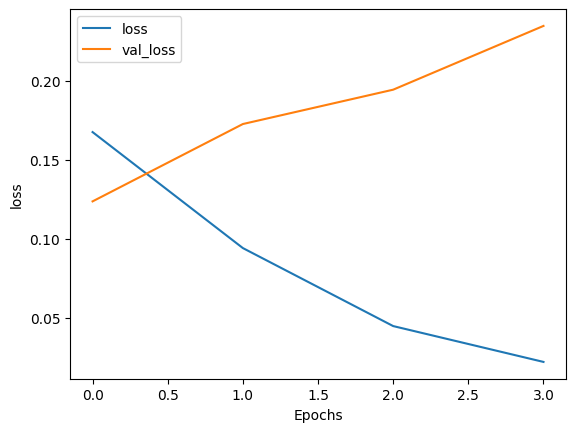

In [59]:
plot_graphs (history, 'loss')

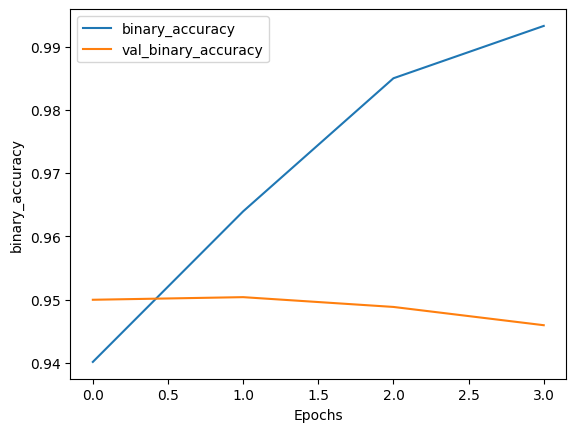

In [60]:
plot_graphs (history, 'binary_accuracy')

In [69]:
sample_example = ["Did I stutter?", "How are you doing?"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len (sample_example) ))
test_data = (test_data.map(to_feature_map) .batch(1))
preds = model.predict(test_data)
print(preds)
threshold = .5 #between 0 and 1
['Insincere' if pred >=threshold else 'Sincere' for pred in preds]

2/2 [==============================] - 0s 38ms/step
[[0.0004889 ]
 [0.00084874]]


['Sincere', 'Sincere']